In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis, pearsonr

In [ ]:
import pandas as pd

# Load the financial data from an Excel file
financial_data = pd.read_excel('/content/drive/MyDrive/Sulema/Sample Data 2013 Jan to 2023 June.xlsx')

# Load the news data from an Excel file
news_data = pd.read_excel('/content/drive/MyDrive/Sulema/Final FIle.xlsx')

# Convert dates to datetime format if necessary
financial_data['Month'] = pd.to_datetime(financial_data['Month'])
news_data['Date'] = pd.to_datetime(news_data['Date'])

# Preview the datasets
financial_data.head()



,Month,FTSE 100 Stock Change in Price,Polarity,FTSE 100 Stock ROI,UK Inflation,FTSE Beta Value,UK LIBOR
0,2013-01-01,6276.899902,0.084828,0.064300,2.4,0.643075,0.005
1,2013-02-01,6360.799805,0.110000,0.013366,2.5,0.471872,0.005
2,2013-03-01,6411.700195,0.083982,0.008002,2.5,0.759414,0.005
3,2013-04-01,6430.100098,0.050441,0.002870,2.2,0.554746,0.005
4,2013-05-01,6583.100098,0.077498,0.023794,2.4,0.720682,0.005


In [ ]:
news_data.head()

,Serial Number,News,Title,News Intro,Date,Url
0,1,GOV.UK,Digest of UK Energy Statistics (DUKES),... 2013: internet content only. 25 July 2013;...,2013-07-25,https://www.gov.uk/government/collections/dige...
1,2,Reuters,Greek finance minister tests EU's ways of winn...,"In Brussels, officials who regard Varoufakis a...",2015-02-10,https://www.reuters.com/article/uk-eurozone-gr...
2,3,Reuters,"In landmark for EU, Ireland leaves its bailout...",Economic recovery is also heavily reliant on e...,2013-12-13,https://www.reuters.com/article/us-ireland-bai...
3,4,ロイター,"Barclays to cut 12000 jobs, pays bigger bonuses",The cuts are not concentrated in any one busin...,2014-02-11,https://jp.reuters.com/article/cbusiness-us-ba...
4,5,Reuters,"HSBC third-quarter profit rises to $5 billion,...",LONDON (Reuters) - HSBC reported a 10 percent ...,2013-11-03,https://www.reuters.com/article/us-hsbc-earnin...


In [ ]:
from textblob import TextBlob
import pandas as pd

# Assuming you have a column 'News Intro' in news_data
def get_polarity(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    else:
        return 0.0  # Neutral polarity for non-string or missing data

news_data['Polarity'] = news_data['News Intro'].apply(get_polarity)

# Join sentiment scores with financial data based on the date (if applicable)
# Assuming you aggregate daily news polarity to monthly by averaging
monthly_sentiment = news_data.groupby(news_data['Date'].dt.to_period('M'))['Polarity'].mean().reset_index()
monthly_sentiment['Date'] = monthly_sentiment['Date'].dt.to_timestamp()

# Merge with financial data
financial_data = pd.merge(financial_data, monthly_sentiment, left_on='Month', right_on='Date', how='left')
financial_data = financial_data.drop(columns=['Date'])

financial_data.head()


,Month,FTSE 100 Stock Change in Price,Polarity_x,FTSE 100 Stock ROI,UK Inflation,FTSE Beta Value,UK LIBOR,Polarity_y,Polarity
0,2013-01-01,6276.899902,0.084828,0.064300,2.4,0.643075,0.005,0.030833,0.030833
1,2013-02-01,6360.799805,0.110000,0.013366,2.5,0.471872,0.005,0.000000,0.000000
2,2013-03-01,6411.700195,0.083982,0.008002,2.5,0.759414,0.005,0.000000,0.000000
3,2013-04-01,6430.100098,0.050441,0.002870,2.2,0.554746,0.005,NaN,NaN
4,2013-05-01,6583.100098,0.077498,0.023794,2.4,0.720682,0.005,0.081944,0.081944


In [ ]:
# Descriptive statistics for financial data
desc_stats = financial_data.describe()
desc_stats

,Month,FTSE 100 Stock Change in Price,Polarity_x,FTSE 100 Stock ROI,UK Inflation,FTSE Beta Value,UK LIBOR,Polarity_y,Polarity
count,126,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,120.000000,120.000000
mean,2018-03-17 06:17:08.571428608,6919.421441,0.107660,0.011587,2.599206,0.520423,0.007262,0.032073,0.032073
min,2013-01-01 00:00:00,5577.299805,0.028008,-0.138073,0.200000,-0.090667,0.001000,-0.700000,-0.700000
25%,2015-08-08 18:00:00,6527.375000,0.092053,-0.021365,1.025000,0.315107,0.002500,0.000000,0.000000
50%,2018-03-16 12:00:00,6969.349854,0.107667,0.008056,1.900000,0.516087,0.005000,0.028266,0.028266
75%,2020-10-24 06:00:00,7372.599854,0.125929,0.027366,2.600000,0.693258,0.007500,0.076736,0.076736
max,2023-06-01 00:00:00,7876.299805,0.183336,1.146908,9.600000,1.387883,0.050000,0.433333,0.433333
std,NaN,524.676395,0.027600,0.107965,2.430917,0.288520,0.009418,0.114270,0.114270


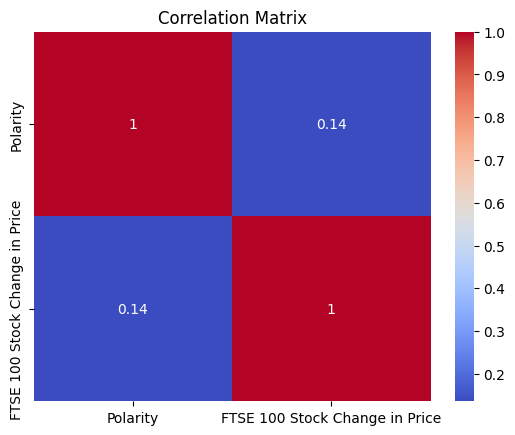

Correlation between Polarity and FTSE 100 Stock Change in Price: 0.136, p-value: 0.139


In [ ]:
# Step 1: Remove NaN or infinite values from the relevant columns
financial_data_clean = financial_data[['Polarity', 'FTSE 100 Stock Change in Price']].replace([np.inf, -np.inf], np.nan).dropna()

# Step 2: Correlation matrix (for the entire dataset)
correlation_matrix = financial_data_clean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Step 3: Specific correlation between Polarity and Stock Price Change
polarity_corr = pearsonr(financial_data_clean['Polarity'], financial_data_clean['FTSE 100 Stock Change in Price'])
print(f'Correlation between Polarity and FTSE 100 Stock Change in Price: {polarity_corr[0]:.3f}, p-value: {polarity_corr[1]:.3f}')


In [ ]:
# Drop rows with any NaN values in the features or target
financial_data_clean = financial_data.dropna(subset=['Polarity', 'UK Inflation', 'FTSE Beta Value', 'UK LIBOR', 'FTSE 100 Stock Change in Price'])

# Prepare data for regression
X = financial_data_clean[['Polarity', 'UK Inflation', 'FTSE Beta Value', 'UK LIBOR']]
y = financial_data_clean['FTSE 100 Stock Change in Price']

# Linear regression model
regressor = LinearRegression()
regressor.fit(X, y)

# Predictions
y_pred = regressor.predict(X)

# Coefficients and performance metrics
print('Coefficients:', regressor.coef_)
print('Intercept:', regressor.intercept_)
print('Mean squared error:', mean_squared_error(y, y_pred))
print('R2 score:', r2_score(y, y_pred))


Coefficients: [ 286.82953705  111.17342269  -68.75584246 1099.94774685]
Intercept: 6658.52302941772
Mean squared error: 182368.32841120052
R2 score: 0.32362504622684285


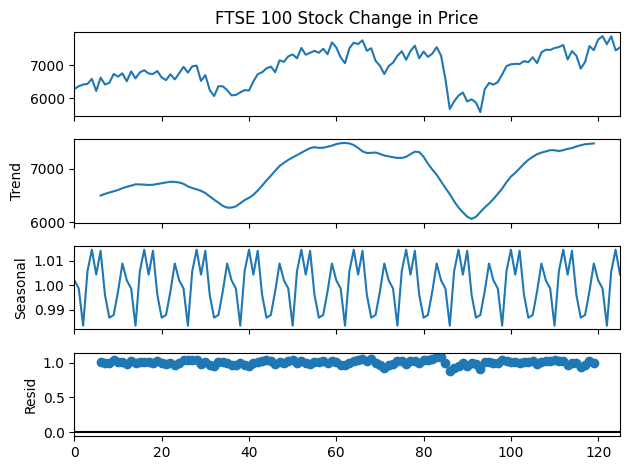

ADF Statistic: -2.620818113809163
p-value: 0.08877046581664577


In [ ]:
# Decompose the time series to observe trend, seasonality, and residuals
result = seasonal_decompose(financial_data['FTSE 100 Stock Change in Price'], model='multiplicative', period=12)
result.plot()
plt.show()

# Check for stationarity using Augmented Dickey-Fuller test
adf_test = adfuller(financial_data['FTSE 100 Stock Change in Price'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')


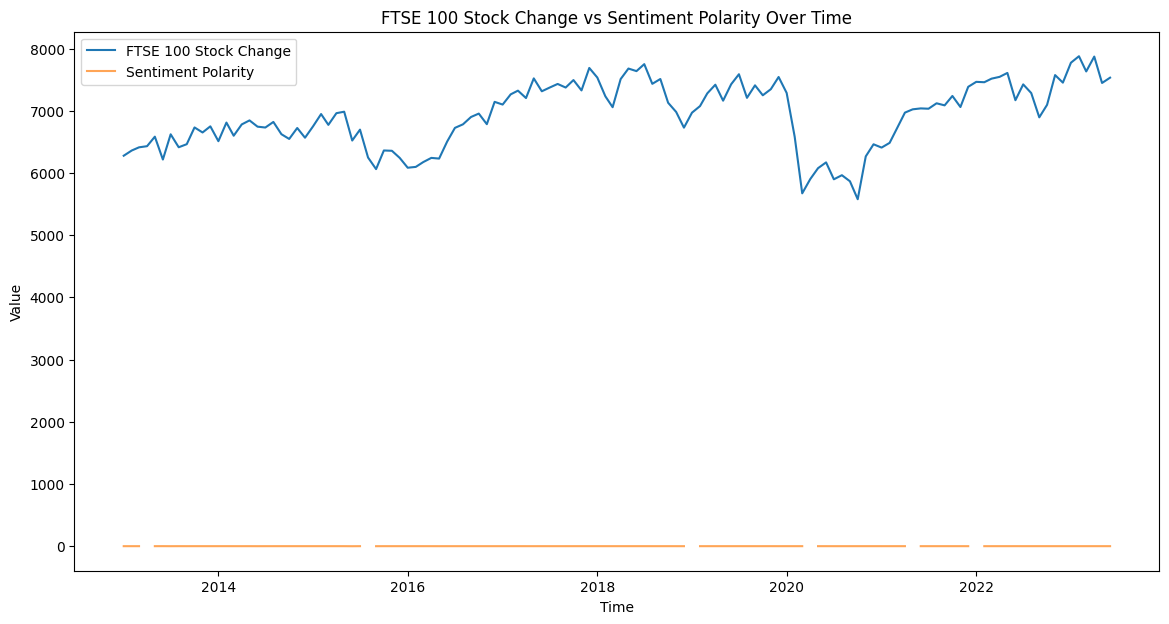

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(financial_data['Month'], financial_data['FTSE 100 Stock Change in Price'], label='FTSE 100 Stock Change')
plt.plot(financial_data['Month'], financial_data['Polarity'], label='Sentiment Polarity', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('FTSE 100 Stock Change vs Sentiment Polarity Over Time')
plt.legend()
plt.show()


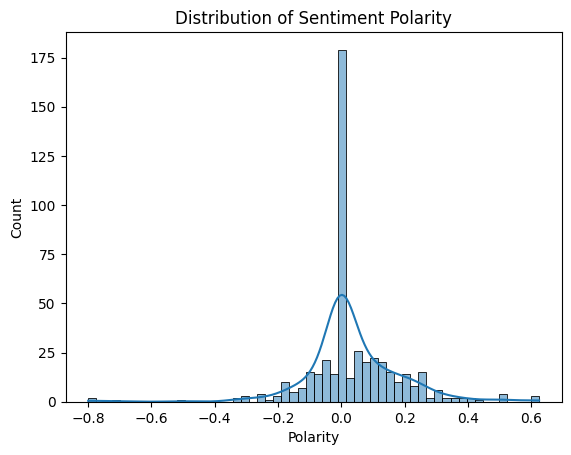

In [ ]:
# Distribution of sentiment polarity
sns.histplot(news_data['Polarity'], kde=True)
plt.title('Distribution of Sentiment Polarity')
plt.show()


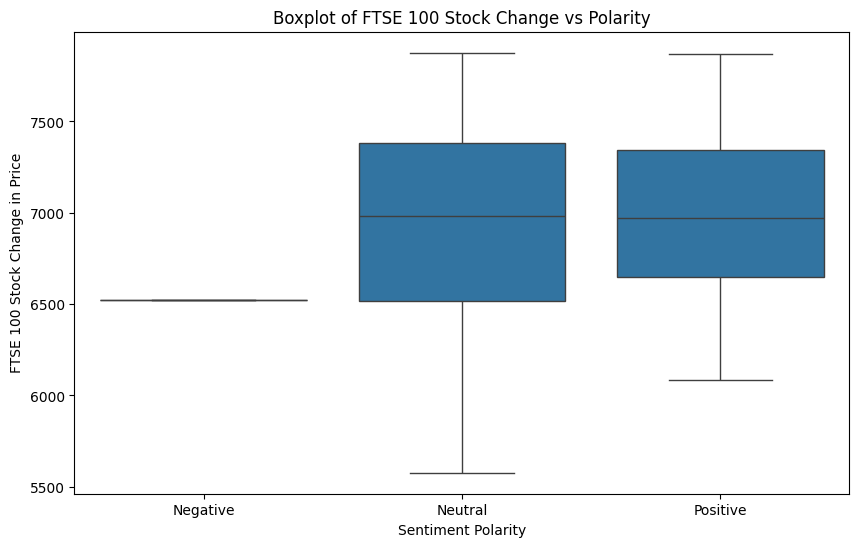

In [ ]:
# Step 1: Handle NaN values
financial_data = financial_data.dropna(subset=['Polarity', 'FTSE 100 Stock Change in Price'])

# Step 2: Categorize Polarity into bins and plot
polarity_categories = pd.cut(financial_data['Polarity'], bins=3, labels=['Negative', 'Neutral', 'Positive'])

# Step 3: Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=polarity_categories, y=financial_data['FTSE 100 Stock Change in Price'])
plt.title('Boxplot of FTSE 100 Stock Change vs Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('FTSE 100 Stock Change in Price')
plt.show()


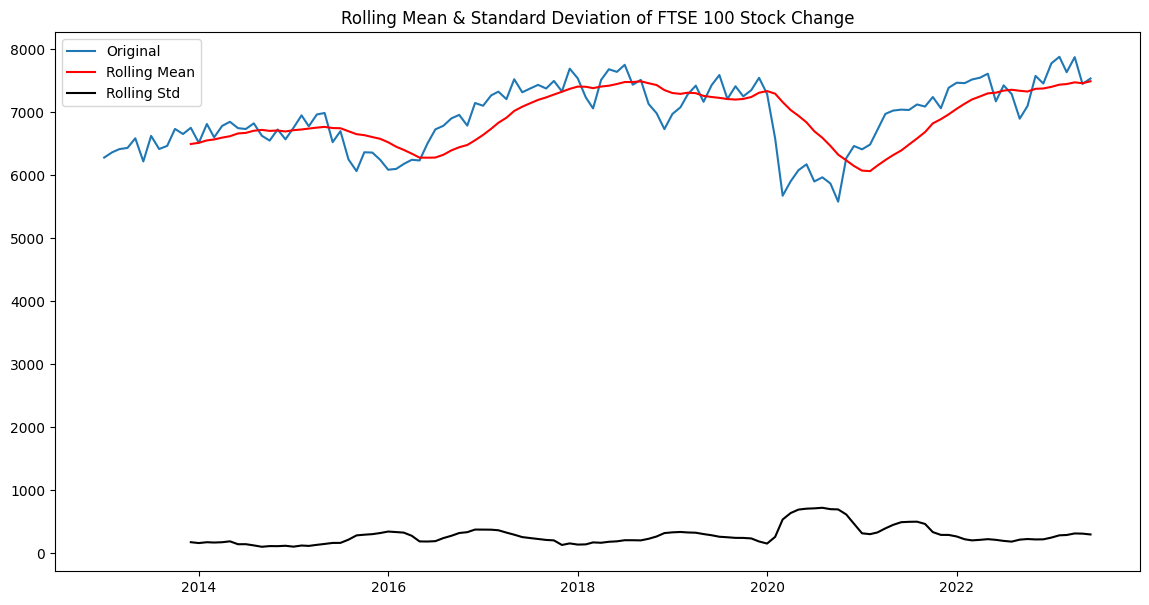

In [ ]:
# Rolling mean and standard deviation for stock changes
rolling_mean = financial_data['FTSE 100 Stock Change in Price'].rolling(window=12).mean()
rolling_std = financial_data['FTSE 100 Stock Change in Price'].rolling(window=12).std()

plt.figure(figsize=(14, 7))
plt.plot(financial_data['Month'], financial_data['FTSE 100 Stock Change in Price'], label='Original')
plt.plot(financial_data['Month'], rolling_mean, color='red', label='Rolling Mean')
plt.plot(financial_data['Month'], rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation of FTSE 100 Stock Change')
plt.legend()
plt.show()


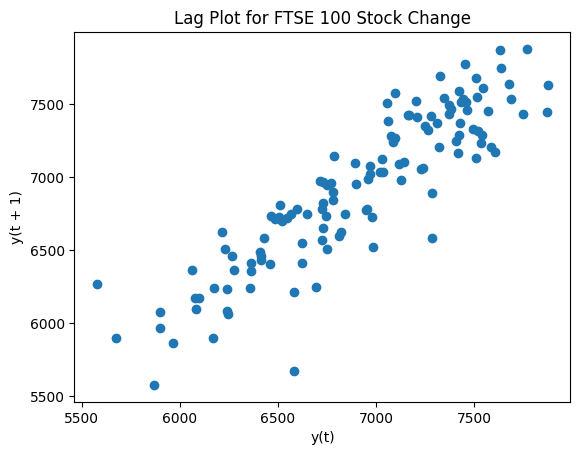

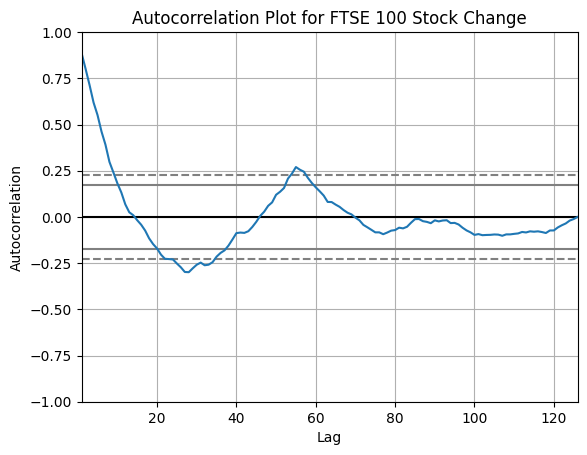

In [ ]:
# Lag plot to check for any autocorrelation
pd.plotting.lag_plot(financial_data['FTSE 100 Stock Change in Price'])
plt.title('Lag Plot for FTSE 100 Stock Change')
plt.show()

# Autocorrelation plot
pd.plotting.autocorrelation_plot(financial_data['FTSE 100 Stock Change in Price'])
plt.title('Autocorrelation Plot for FTSE 100 Stock Change')
plt.show()


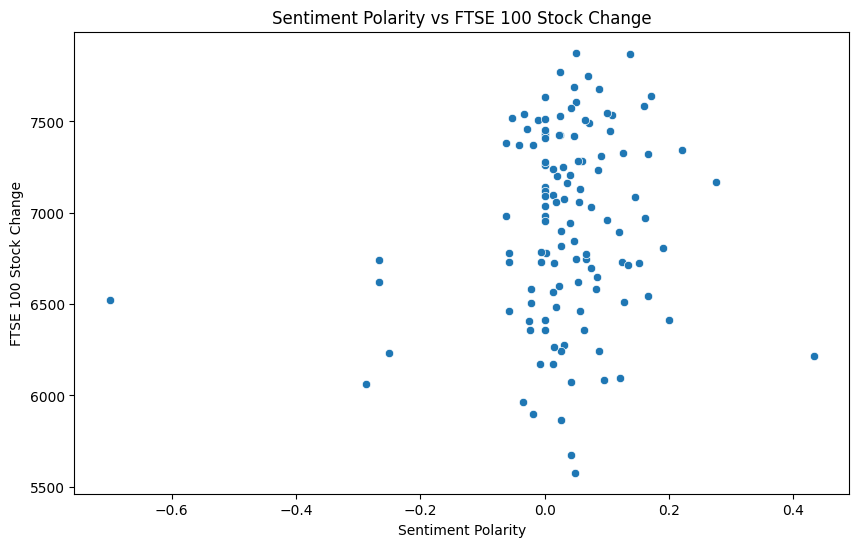

In [ ]:
# Scatter plot of sentiment polarity vs stock price change
plt.figure(figsize=(10, 6))
sns.scatterplot(x=financial_data['Polarity'], y=financial_data['FTSE 100 Stock Change in Price'])
plt.title('Sentiment Polarity vs FTSE 100 Stock Change')
plt.xlabel('Sentiment Polarity')
plt.ylabel('FTSE 100 Stock Change')
plt.show()



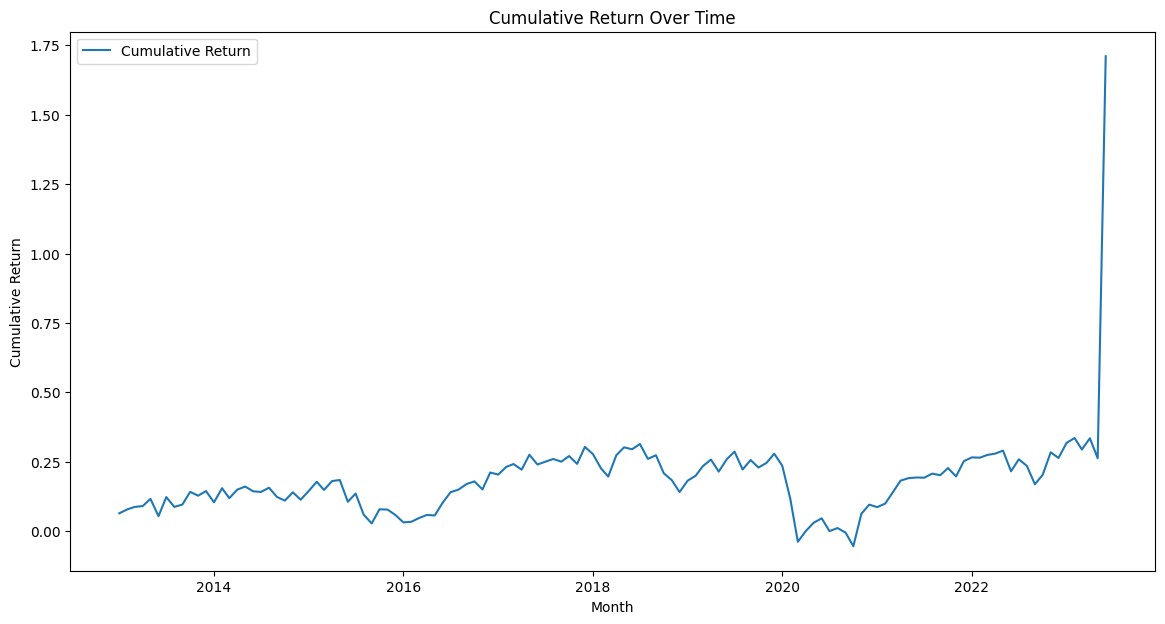

In [ ]:
# Calculate and plot the cumulative return based on sentiment
financial_data['Cumulative Return'] = (1 + financial_data['FTSE 100 Stock ROI']).cumprod() - 1
plt.figure(figsize=(14, 7))
sns.lineplot(x=financial_data['Month'], y=financial_data['Cumulative Return'], label='Cumulative Return')
plt.title('Cumulative Return Over Time')
plt.show()


In [ ]:
# Print the list of columns to check their names
print(financial_data.columns)

Index(['Month', 'FTSE 100 Stock Change in Price', 'Polarity_x',
       'FTSE 100 Stock ROI', 'UK Inflation', 'FTSE Beta Value', 'UK LIBOR',
       'Polarity_y', 'Polarity', 'Cumulative Return'],
      dtype='object')


Cross-validation R2 scores: [0.18224788 0.14755678 0.13095586 0.26005594 0.48421492]
Average cross-validation R2 score: 0.24100627804048075
Mean Squared Error: 286924.3985270635
R2 Score: 0.10667883592192329


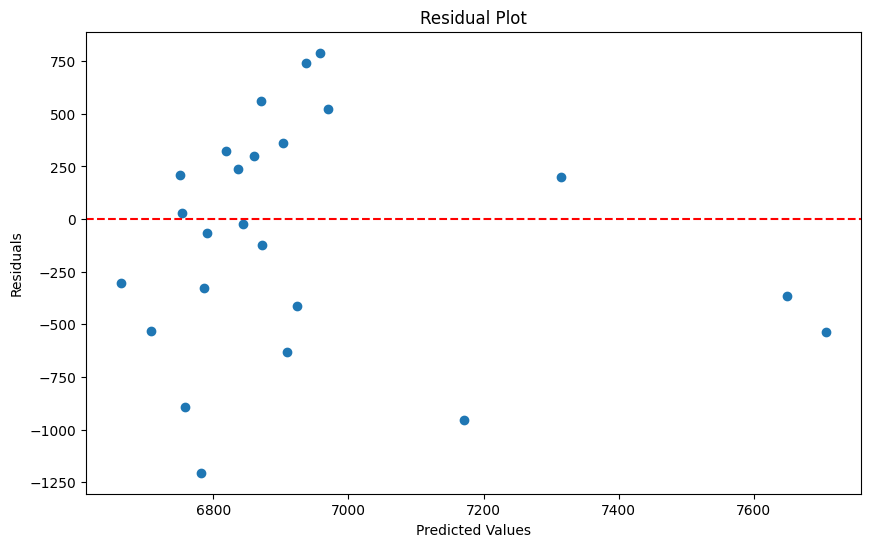

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Use the correct columns based on your dataset
X = financial_data[['Polarity', 'UK Inflation', 'FTSE Beta Value', 'UK LIBOR']]
y = financial_data['FTSE 100 Stock Change in Price']

# Add a constant term for intercept in OLS model
X_with_const = sm.add_constant(X)

# 1. Cross-Validation
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
regressor = LinearRegression()

# Perform 5-fold cross-validation
cross_val_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='r2')

# Output the cross-validation scores
print(f"Cross-validation R2 scores: {cross_val_scores}")
print(f"Average cross-validation R2 score: {cross_val_scores.mean()}")

# 2. Fit the Model and Make Predictions
# Fit the model on the training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Print model performance metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

# 3. Residual Analysis
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()




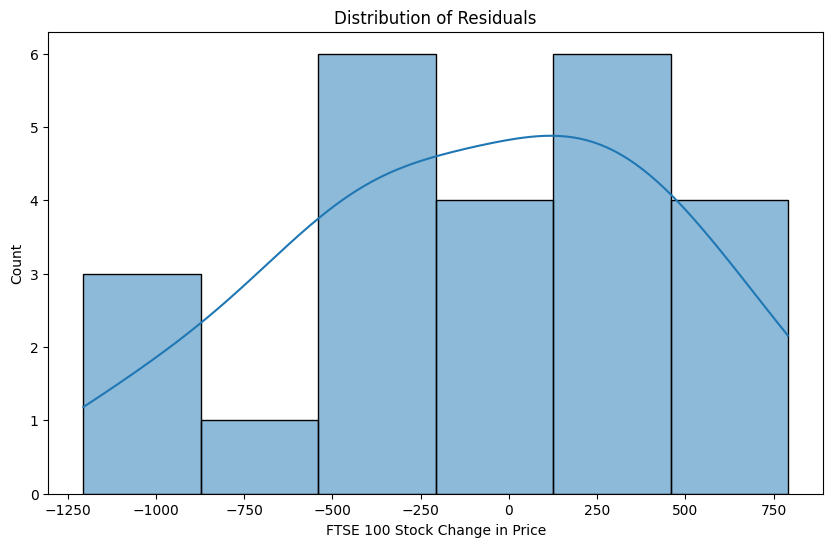

In [ ]:
# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'final_estimator__n_estimators': 100, 'gbr__n_estimators': 100, 'rf__n_estimators': 100, 'xgbr__n_estimators': 100}
Mean Squared Error: 215691.6909338117
R2 Score: 0.3284574145102298


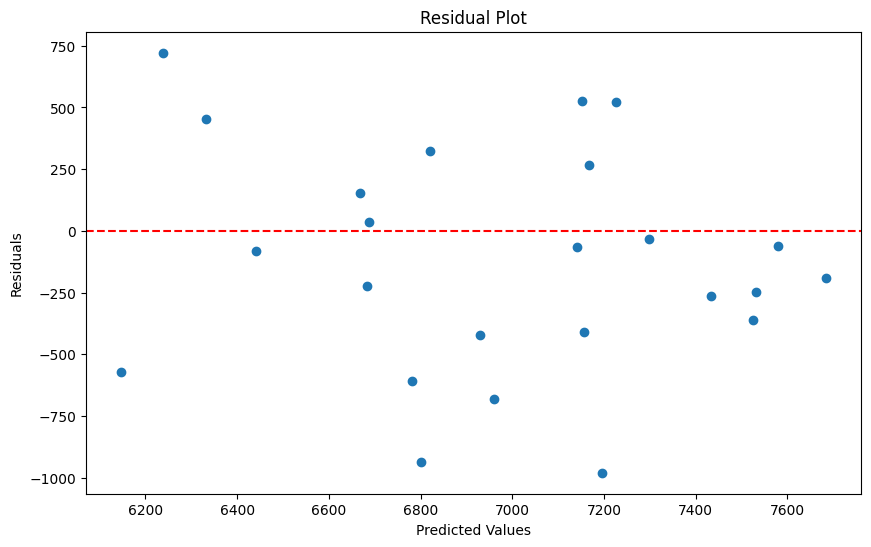

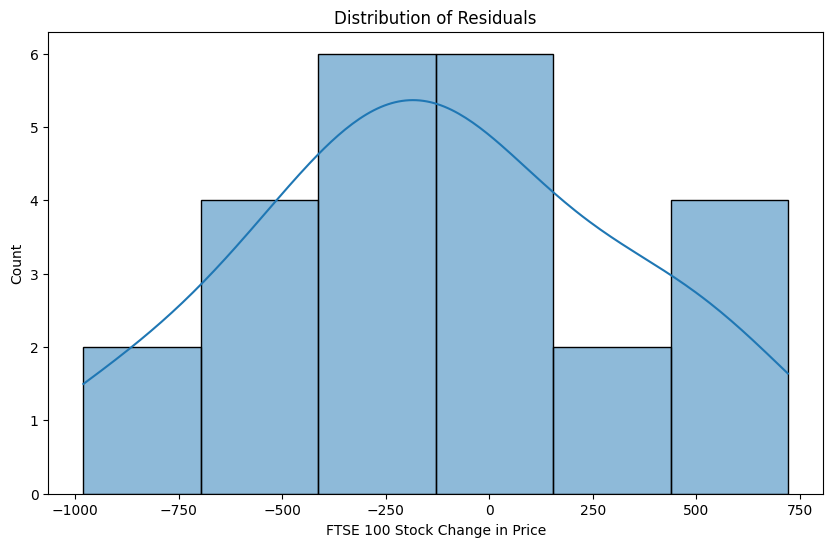

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Load and prepare the data
X = financial_data[['Polarity', 'UK Inflation', 'FTSE Beta Value', 'UK LIBOR']]
y = financial_data['FTSE 100 Stock Change in Price']

# Feature Engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Define models
gbr = GradientBoostingRegressor(random_state=42)
xgbr = XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Stacking Ensemble
stacked_model = StackingRegressor(
    estimators=[('gbr', gbr), ('xgbr', xgbr), ('rf', rf)],
    final_estimator=GradientBoostingRegressor(n_estimators=100, random_state=42)
)

# Hyperparameter Tuning for the Stacked Model
param_grid = {
    'gbr__n_estimators': [100, 200],
    'xgbr__n_estimators': [100, 200],
    'rf__n_estimators': [100, 200],
    'final_estimator__n_estimators': [100, 200]
}

grid_search = GridSearchCV(estimator=stacked_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()


Gradient Boosting MSE: 167468.62637052347, R²: 0.4785969090678026
XGBoost MSE: 169885.18779201308, R²: 0.4710730962683566
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best XGBoost MSE: 159437.82971368232, R²: 0.5036002920313709
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
RFE Gradient Boosting MSE: 164756.59244769707, R²: 0.4870406570146333


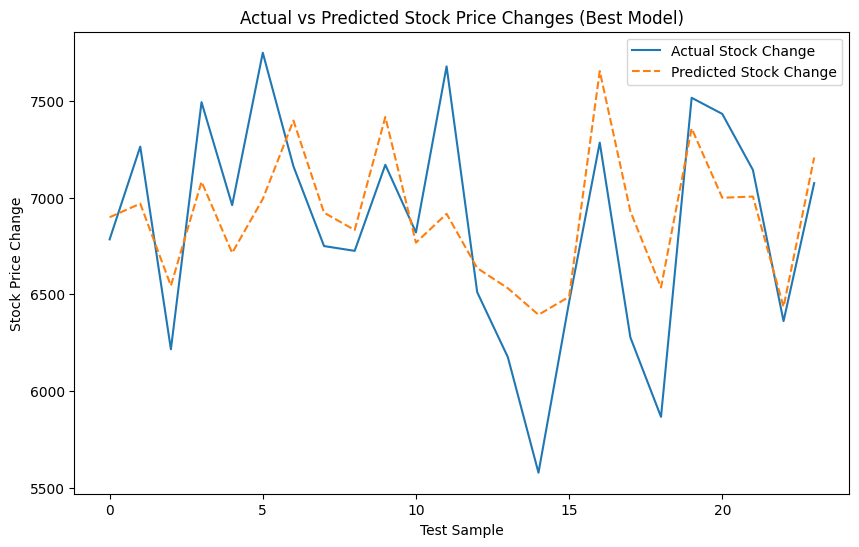

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Load and prepare the data (assuming financial_data is your cleaned DataFrame)
X = financial_data[['Polarity', 'UK Inflation', 'FTSE Beta Value', 'UK LIBOR']]
y = financial_data['FTSE 100 Stock Change in Price']

# 1. Feature Engineering - Adding Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# 2. Use More Advanced Models

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# XGBoost Regressor
xgbr = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)

# Evaluate and compare the models
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

mse_xgbr = mean_squared_error(y_test, y_pred_xgbr)
r2_xgbr = r2_score(y_test, y_pred_xgbr)

print(f"Gradient Boosting MSE: {mse_gbr}, R²: {r2_gbr}")
print(f"XGBoost MSE: {mse_xgbr}, R²: {r2_xgbr}")

# 3. Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgbr, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_xgbr = grid_search.best_estimator_
y_pred_best_xgbr = best_xgbr.predict(X_test)

mse_best_xgbr = mean_squared_error(y_test, y_pred_best_xgbr)
r2_best_xgbr = r2_score(y_test, y_pred_best_xgbr)

print(f"Best XGBoost MSE: {mse_best_xgbr}, R²: {r2_best_xgbr}")
print(f"Best parameters found: {grid_search.best_params_}")

# 4. Feature Selection - Optional step if you want to try it
from sklearn.feature_selection import RFE

# Recursive Feature Elimination
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_train, y_train)

# Select the most important features and retrain the model
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

model.fit(X_train_rfe, y_train)
y_pred_rfe = model.predict(X_test_rfe)

mse_rfe = mean_squared_error(y_test, y_pred_rfe)
r2_rfe = r2_score(y_test, y_pred_rfe)

print(f"RFE Gradient Boosting MSE: {mse_rfe}, R²: {r2_rfe}")

# Plot actual vs predicted stock price changes for the best model
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Stock Change')
plt.plot(y_pred_best_xgbr, label='Predicted Stock Change', linestyle='--')
plt.title('Actual vs Predicted Stock Price Changes (Best Model)')
plt.xlabel('Test Sample')
plt.ylabel('Stock Price Change')
plt.legend()
plt.show()


Cross-validation R2 scores: [0.40892389 0.43264034 0.43600478 0.61048926 0.55894055]
Average cross-validation R2 score: 0.48939976302985844


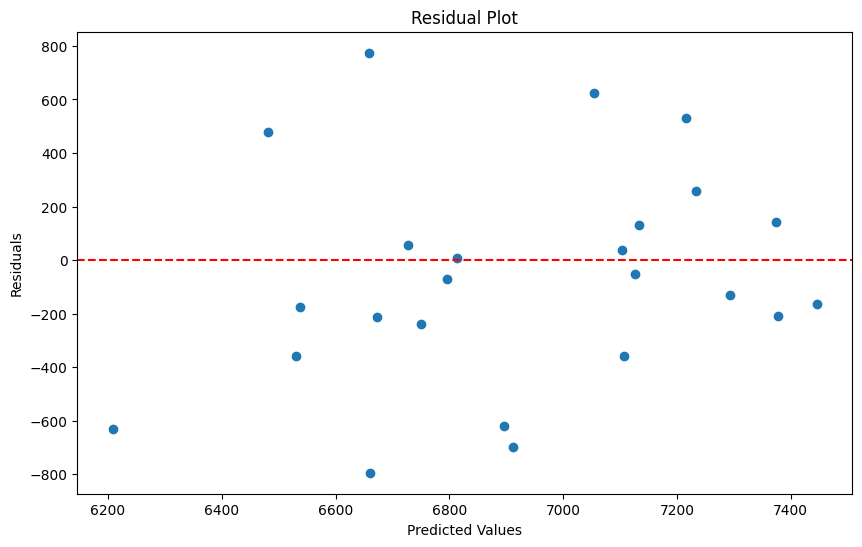

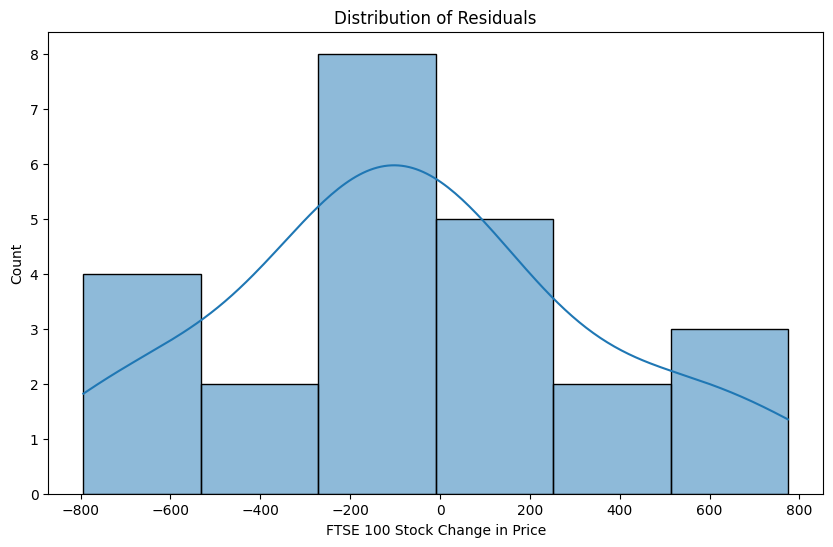

                                  OLS Regression Results                                  
Dep. Variable:     FTSE 100 Stock Change in Price   R-squared:                       0.377
Model:                                        OLS   Adj. R-squared:                  0.350
Method:                             Least Squares   F-statistic:                     13.78
Date:                            Mon, 12 Aug 2024   Prob (F-statistic):           8.00e-09
Time:                                    22:31:13   Log-Likelihood:                -711.00
No. Observations:                              96   AIC:                             1432.
Df Residuals:                                  91   BIC:                             1445.
Df Model:                                       4                                         
Covariance Type:                        nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Load and prepare the data
X = financial_data[['Polarity', 'UK Inflation', 'FTSE Beta Value', 'UK LIBOR']]
y = financial_data['FTSE 100 Stock Change in Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)

# 1. Cross-Validation
cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validation R2 scores: {cross_val_scores}")
print(f"Average cross-validation R2 score: {cross_val_scores.mean()}")

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# 2. Residual Analysis
residuals = y_test - y_pred

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

# 3. Statistical Significance Testing using OLS from statsmodels
# Add a constant to the features for the OLS regression
X_with_const = sm.add_constant(X_train)

# Fit the OLS model
ols_model = sm.OLS(y_train, X_with_const).fit()

# Print the summary of the OLS regression, which includes t-tests for coefficients and the F-test for the model
print(ols_model.summary())


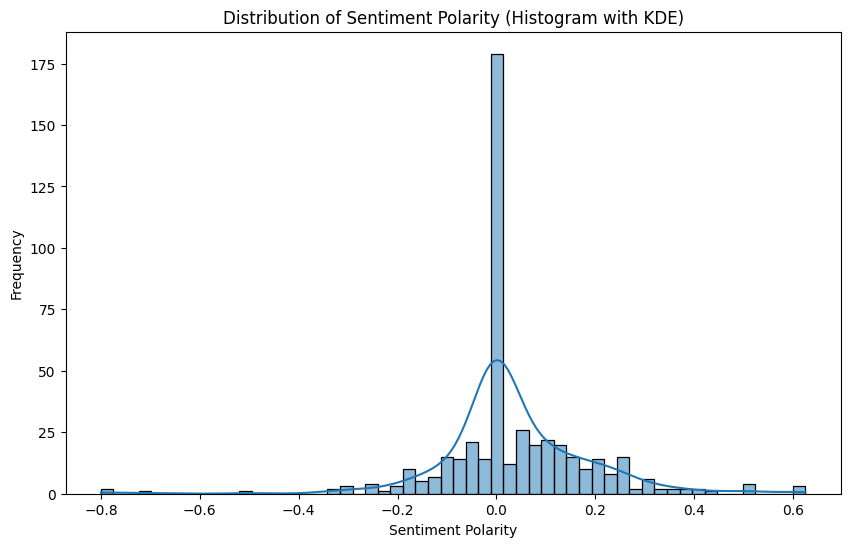

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr

# Assume financial_data and news_data are already preprocessed and cleaned

# Figure 1: Sentiment Polarity Histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(news_data['Polarity'], kde=True)
plt.title('Distribution of Sentiment Polarity (Histogram with KDE)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

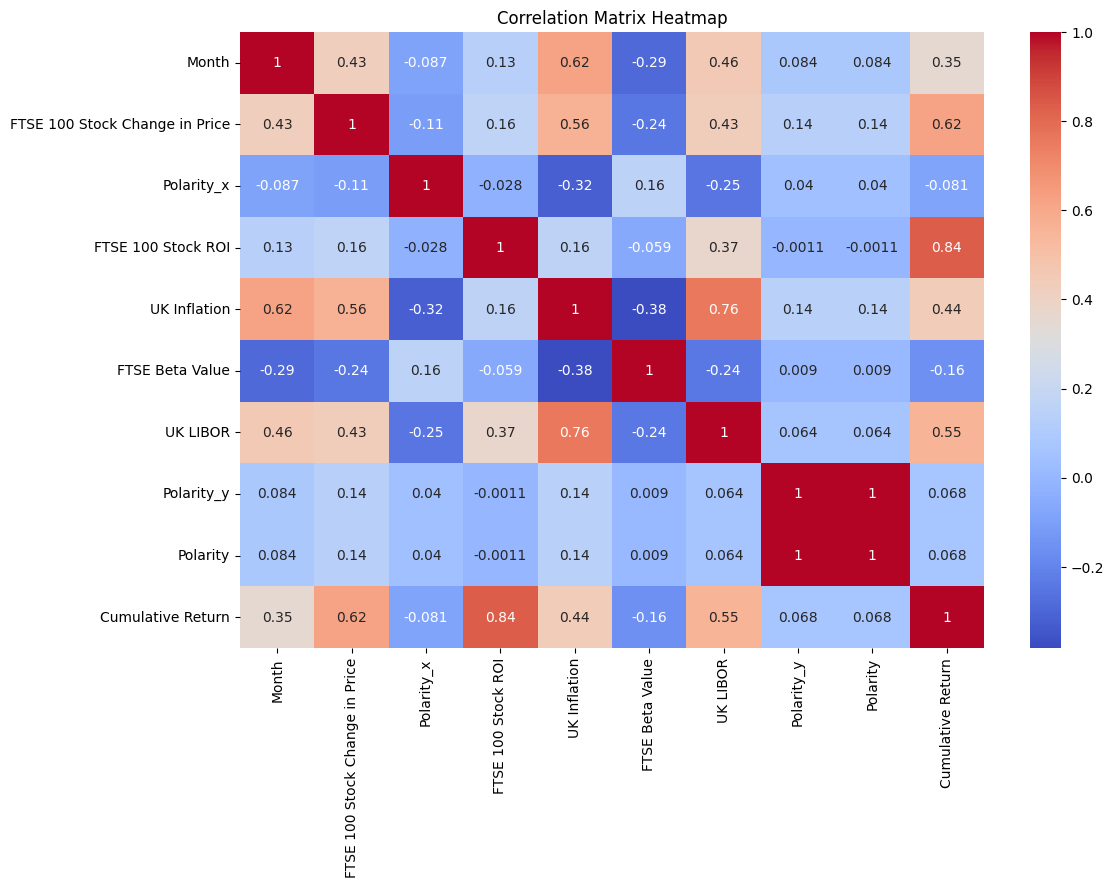

In [ ]:
# Figure 2: Correlation Matrix Heatmap
correlation_matrix = financial_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

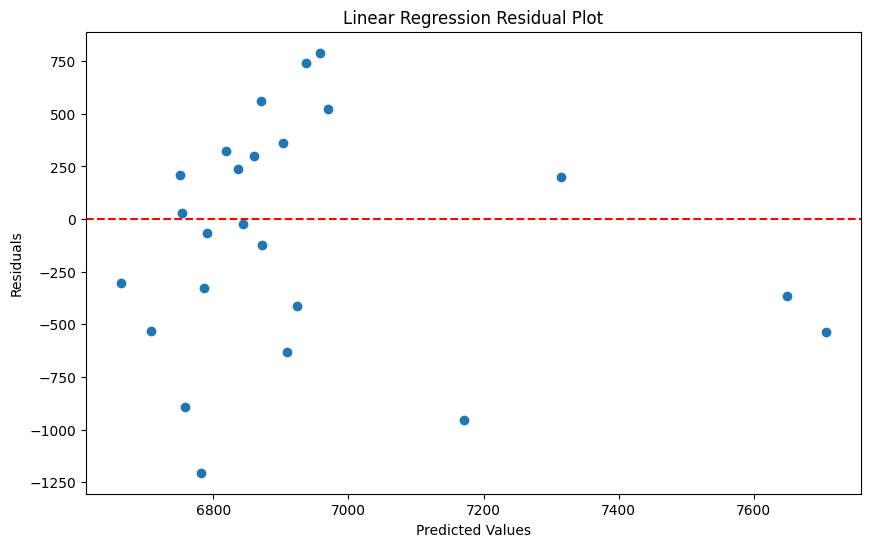

In [ ]:
# Figure 3: Linear Regression Residual Plot
X = financial_data[['Polarity', 'UK Inflation', 'FTSE Beta Value', 'UK LIBOR']]
y = financial_data['FTSE 100 Stock Change in Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Linear Regression Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

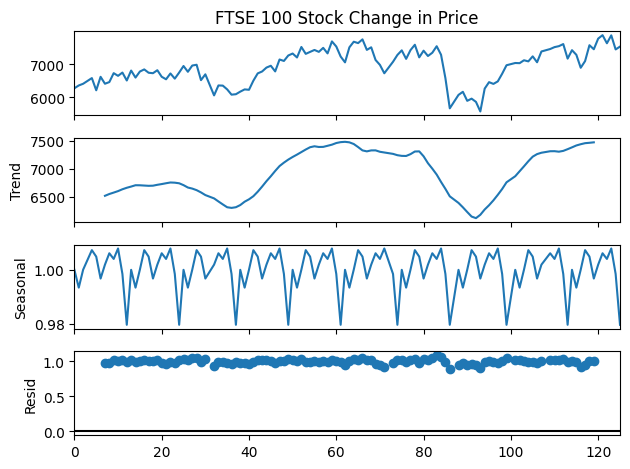

In [ ]:
# Figure 4: Time-Series Decomposition of FTSE 100 Stock Change in Price
result = seasonal_decompose(financial_data['FTSE 100 Stock Change in Price'], model='multiplicative', period=12)
result.plot()
plt.show()

ADF Statistic: -2.7116562080839333
p-value: 0.07204286392774968


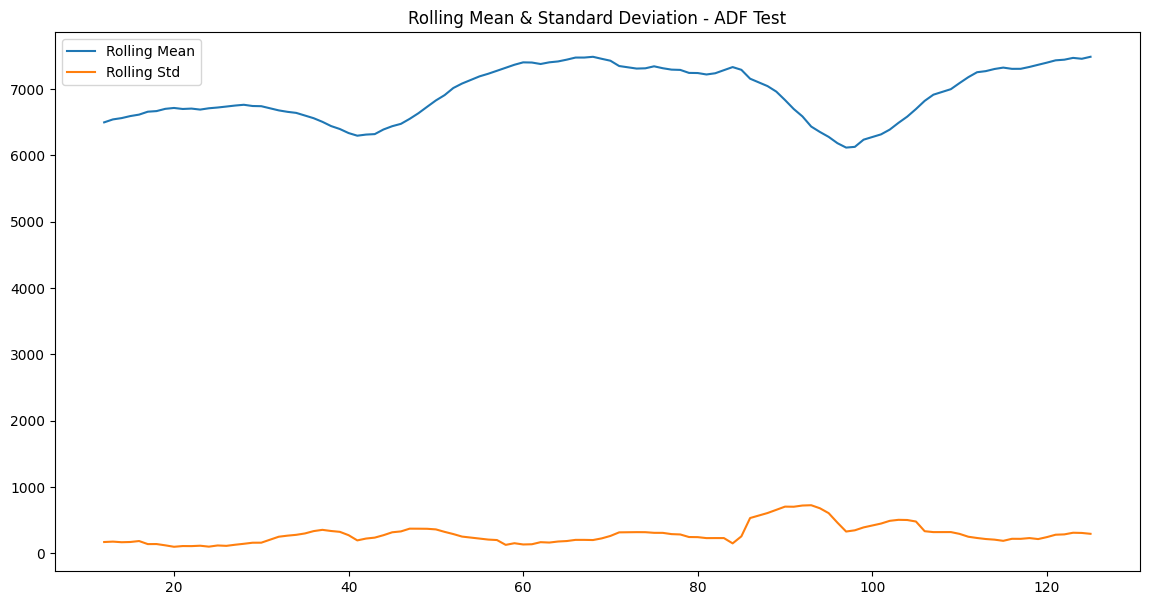

In [ ]:
# Figure 5: Augmented Dickey-Fuller (ADF) Test Results
adf_result = adfuller(financial_data['FTSE 100 Stock Change in Price'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
plt.figure(figsize=(14, 7))
plt.plot(financial_data['FTSE 100 Stock Change in Price'].rolling(window=12).mean(), label='Rolling Mean')
plt.plot(financial_data['FTSE 100 Stock Change in Price'].rolling(window=12).std(), label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation - ADF Test')
plt.legend()
plt.show()

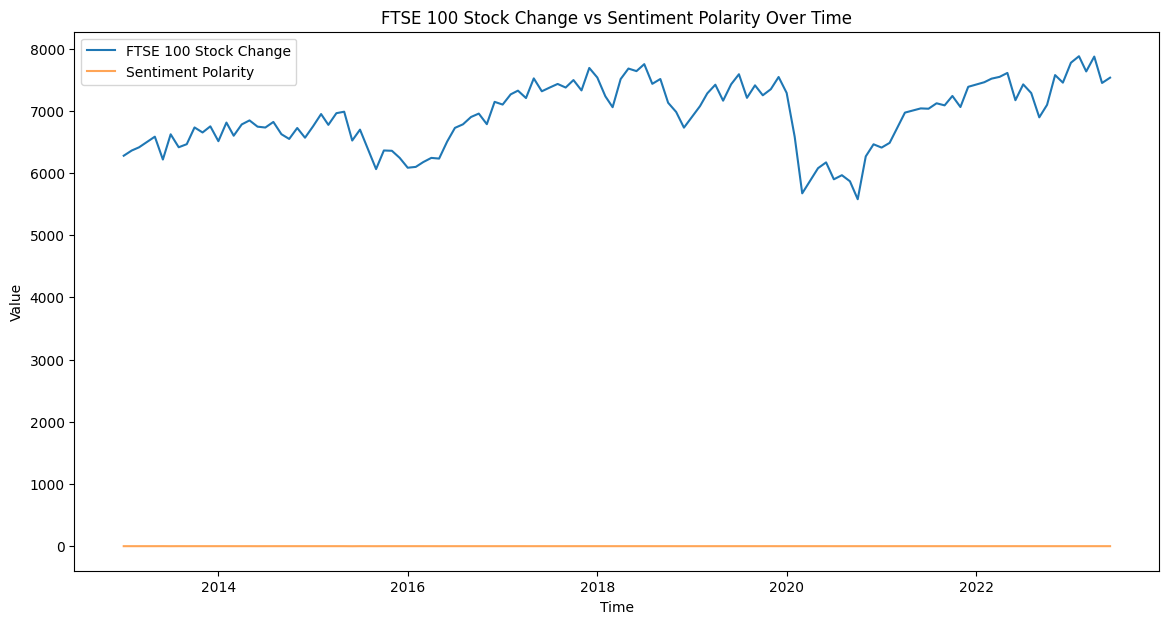

In [ ]:
# Figure 6: Line Plot of Stock Changes and Sentiment Polarity Over Time
plt.figure(figsize=(14, 7))
plt.plot(financial_data['Month'], financial_data['FTSE 100 Stock Change in Price'], label='FTSE 100 Stock Change')
plt.plot(financial_data['Month'], financial_data['Polarity'], label='Sentiment Polarity', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('FTSE 100 Stock Change vs Sentiment Polarity Over Time')
plt.legend()
plt.show()

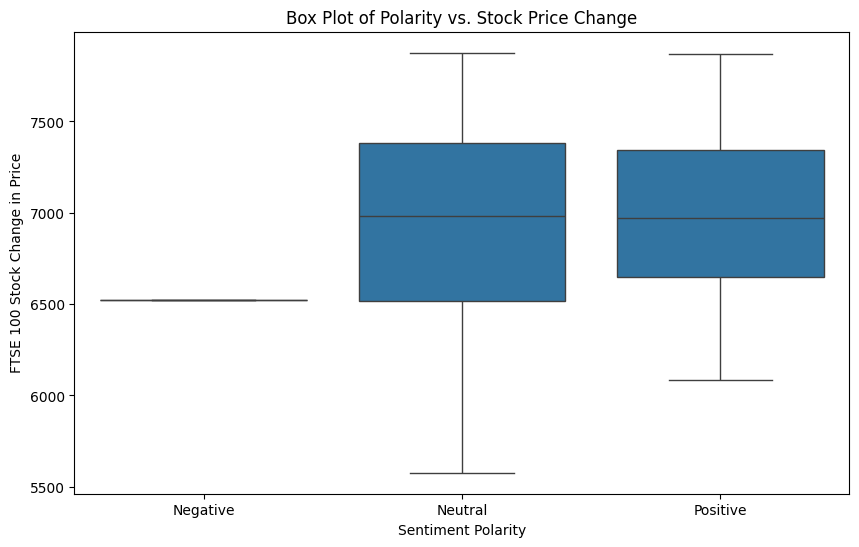

In [ ]:
# Figure 7: Box Plot of Polarity vs. Stock Price Change
plt.figure(figsize=(10, 6))
polarity_categories = pd.cut(financial_data['Polarity'], bins=3, labels=['Negative', 'Neutral', 'Positive'])
sns.boxplot(x=polarity_categories, y=financial_data['FTSE 100 Stock Change in Price'])
plt.title('Box Plot of Polarity vs. Stock Price Change')
plt.xlabel('Sentiment Polarity')
plt.ylabel('FTSE 100 Stock Change in Price')
plt.show()

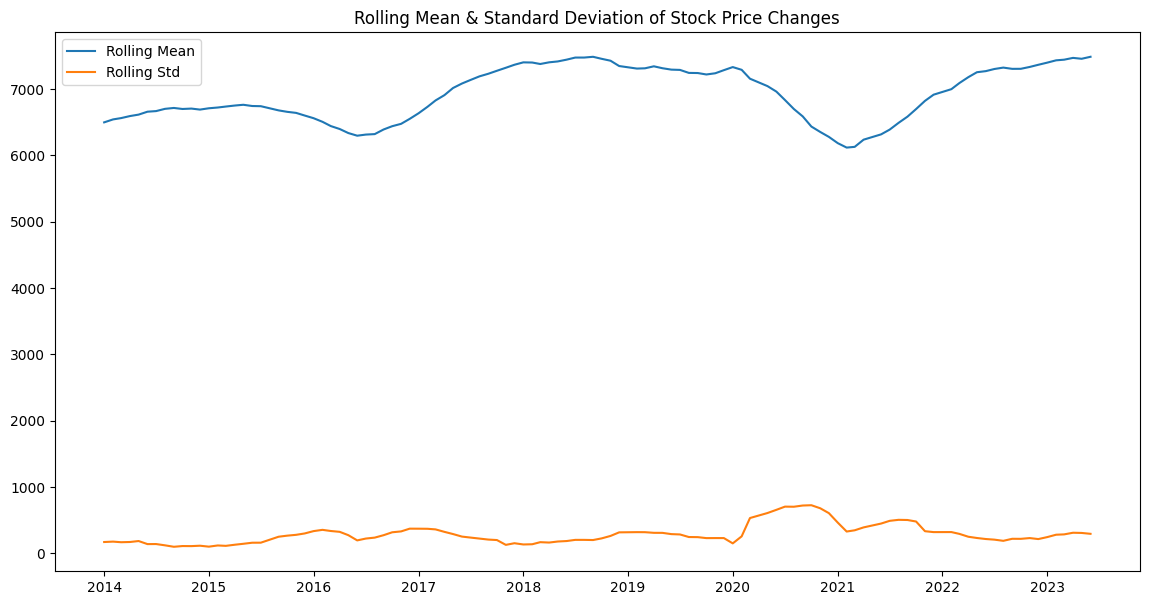

In [ ]:
# Figure 8: Rolling Mean and Standard Deviation of Stock Price Changes
rolling_mean = financial_data['FTSE 100 Stock Change in Price'].rolling(window=12).mean()
rolling_std = financial_data['FTSE 100 Stock Change in Price'].rolling(window=12).std()
plt.figure(figsize=(14, 7))
plt.plot(financial_data['Month'], rolling_mean, label='Rolling Mean')
plt.plot(financial_data['Month'], rolling_std, label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation of Stock Price Changes')
plt.legend()
plt.show()

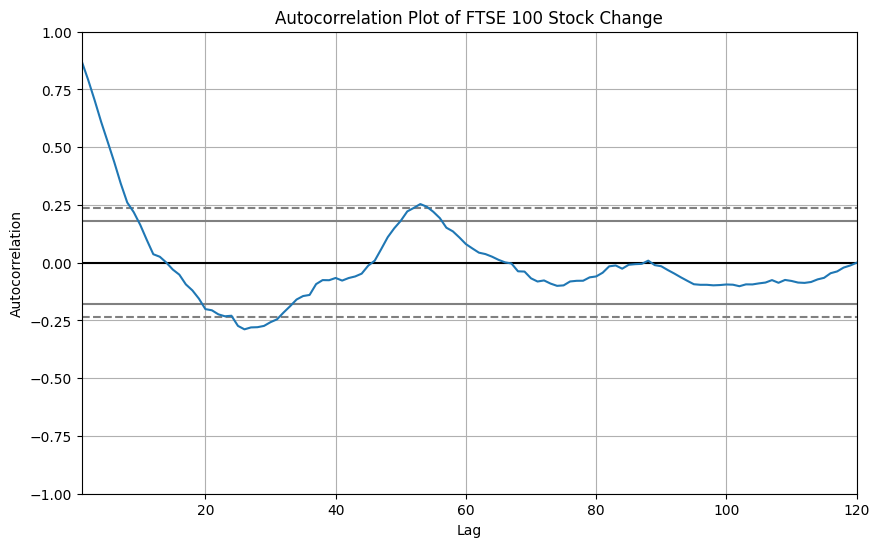

In [ ]:
# Figure 9: Autocorrelation Plot of FTSE 100 Stock Change
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(financial_data['FTSE 100 Stock Change in Price'])
plt.title('Autocorrelation Plot of FTSE 100 Stock Change')
plt.show()

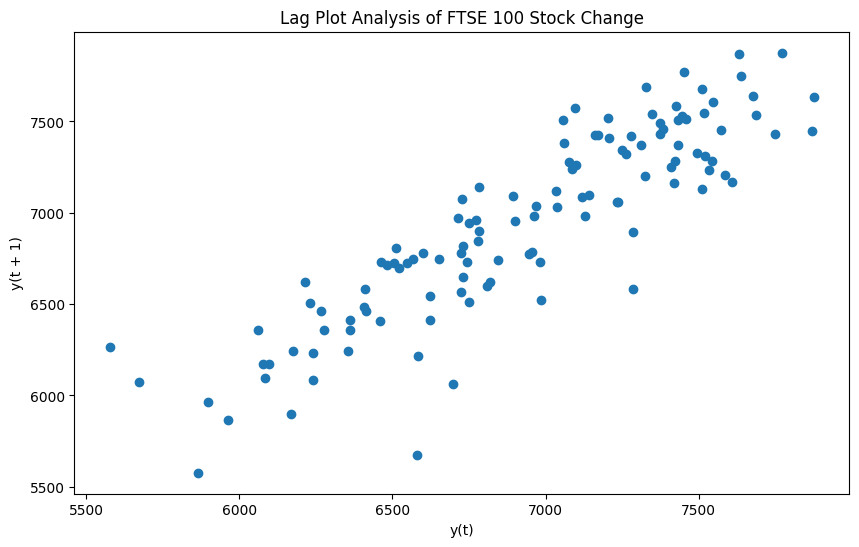

In [ ]:
# Figure 10: Lag Plot Analysis of FTSE 100 Stock Change
plt.figure(figsize=(10, 6))
pd.plotting.lag_plot(financial_data['FTSE 100 Stock Change in Price'])
plt.title('Lag Plot Analysis of FTSE 100 Stock Change')
plt.show()

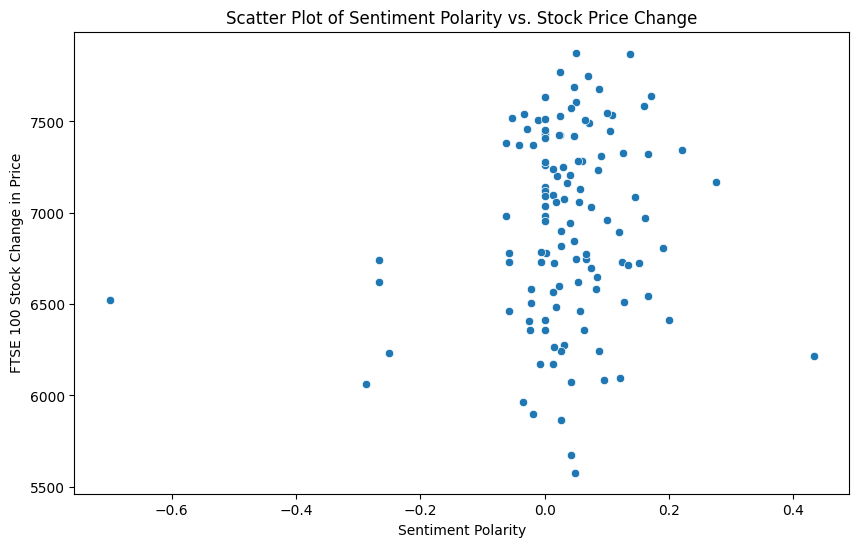

In [ ]:
# Figure 11: Scatter Plot of Sentiment Polarity vs. Stock Price Change
plt.figure(figsize=(10, 6))
sns.scatterplot(x=financial_data['Polarity'], y=financial_data['FTSE 100 Stock Change in Price'])
plt.title('Scatter Plot of Sentiment Polarity vs. Stock Price Change')
plt.xlabel('Sentiment Polarity')
plt.ylabel('FTSE 100 Stock Change in Price')
plt.show()

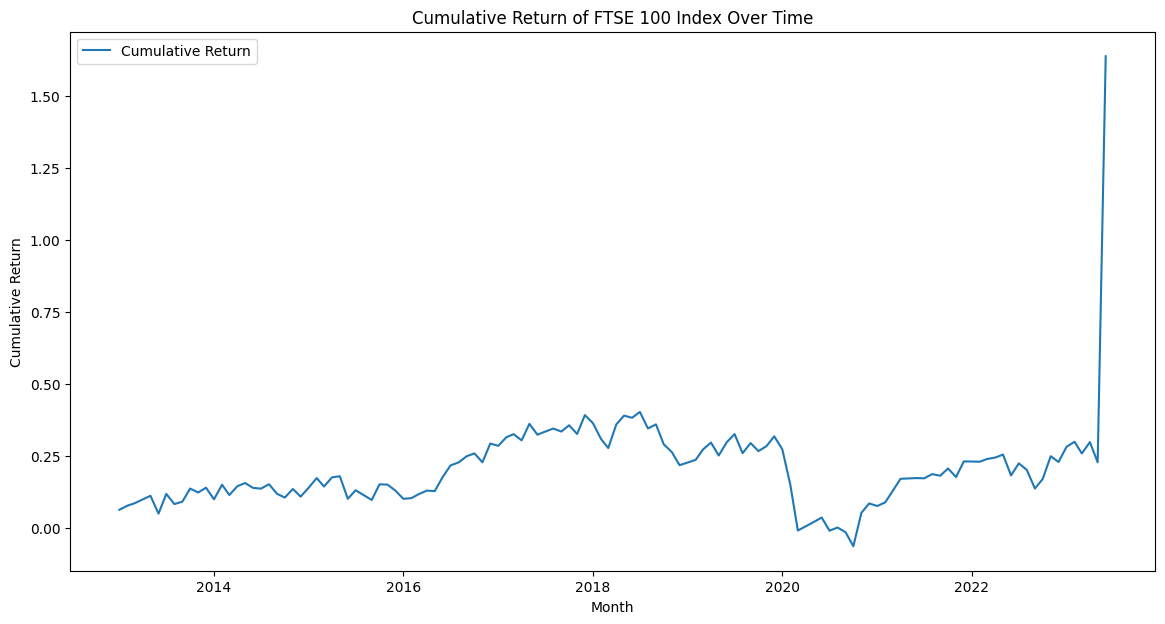

In [ ]:
# Figure 12: Cumulative Return of FTSE 100 Index Over Time
financial_data['Cumulative Return'] = (1 + financial_data['FTSE 100 Stock ROI']).cumprod() - 1
plt.figure(figsize=(14, 7))
sns.lineplot(x=financial_data['Month'], y=financial_data['Cumulative Return'], label='Cumulative Return')
plt.title('Cumulative Return of FTSE 100 Index Over Time')
plt.show()

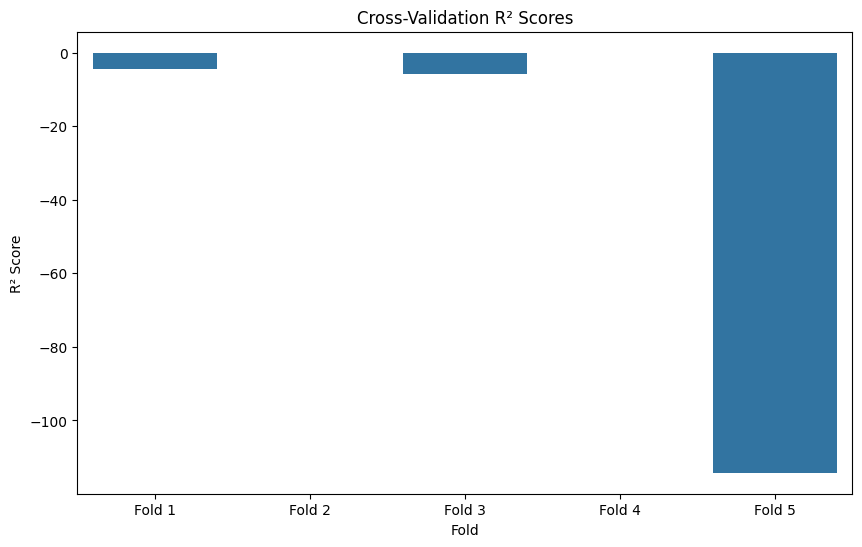

In [ ]:
# Figure 13: Cross-Validation R² Scores
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
plt.figure(figsize=(10, 6))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores)
plt.title('Cross-Validation R² Scores')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.show()

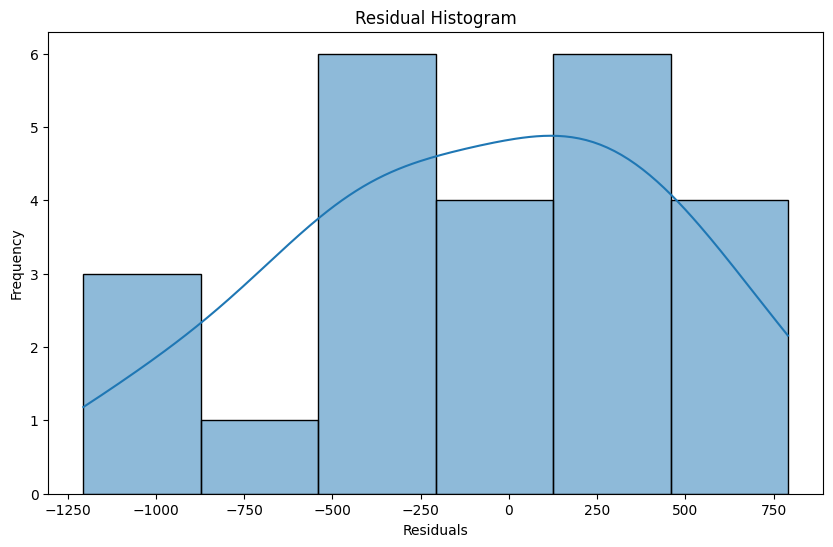

In [ ]:
# Figure 14: Residual Histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

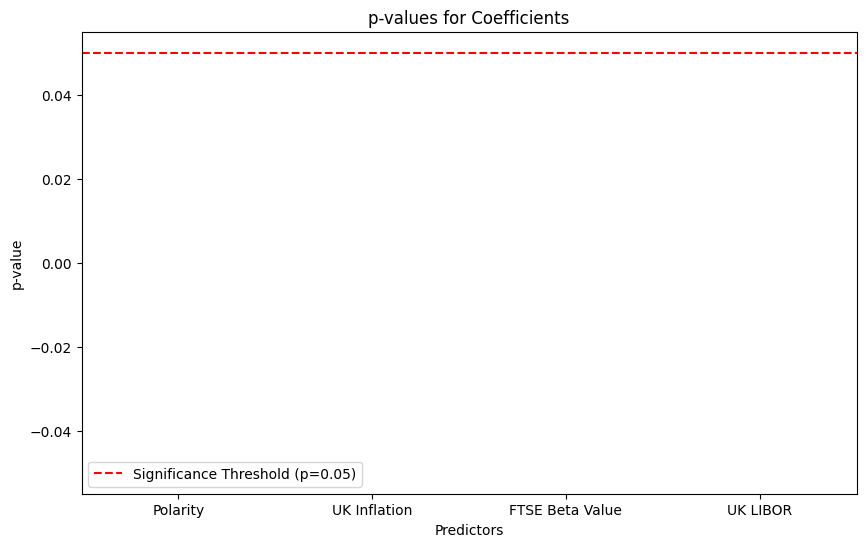

In [ ]:
import scipy.stats as stats

# Figure 15: Model Significance (t-tests and F-tests)
# This is usually a table, but for visualization, we can show the significance of coefficients
t_stats = model.coef_ / np.std(X_train, 0)
p_values = [2 * (1 - stats.t.cdf(np.abs(t), len(y_train) - 1)) for t in t_stats]

plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns, y=p_values)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.title('p-values for Coefficients')
plt.xlabel('Predictors')
plt.ylabel('p-value')
plt.legend()
plt.show()
